In [4]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import sklearn
import sys, pickle, os, glob, re, math

if '../code' not in sys.path: sys.path.append('../code')

from em_gmm import estep, TFGMM, EPS

dtype='float32'

In [2]:
# Verify that we get similar likelihoods with e step.

# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

with tf.Session() as sess:
    mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.41734701  0.02101237  0.49578625  0.43248503  0.47930253]
 [ 0.32740948  0.02201986  0.27971235  0.27048678  0.27233792]
 [ 0.25524351  0.95696777  0.22450141  0.29702819  0.24835955]]
log likelihoods    [[ 0.41734701  0.02101237  0.49578625  0.43248503  0.47930253]
 [ 0.32740948  0.02201986  0.27971235  0.27048678  0.27233792]
 [ 0.25524351  0.95696777  0.22450141  0.29702819  0.24835955]]
K=0 rmse=1.4264448766934932e-16
K=1 rmse=8.068235998053637e-17
K=2 rmse=1.1171403689612728e-16


means
[[ 10.00753212   7.93781853]
 [ 20.17580223  19.77316856]
 [  0.06342117   0.26002195]]
covars
[[  1.4506613   14.84775257]
 [  0.74395043   1.05724394]
 [ 10.45617199   0.57037902]]
weights
[ 0.34550312  0.33333334  0.32116354]


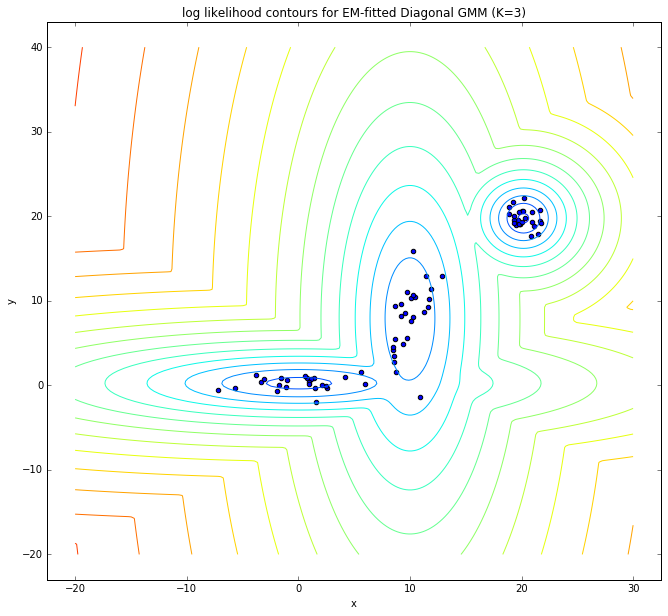

In [5]:
### Check that EM is working on small 2D example
# Note we intentionally shear the Gaussians to see how the model handles it.

n_samples = 25
np.random.seed(1)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return (np.dot(rs, shear.T) + shift)
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[5, 0], [0, 1]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3]).astype(dtype)

gmm = TFGMM(n_components=3, n_iter=100, n_init=3, tol=EPS)
gmm.fit(X)
assert gmm.converged_

for i in ['means', 'covars', 'weights']:
    print('{}\n{}'.format(i, getattr(gmm, i + '_')))

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
x = np.linspace(-20.0, 30.0, 200)
y = np.linspace(-20.0, 40.0, 200)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T.astype(dtype)# todo test with alt type when fixed
plt.figure(figsize=(11, 10))
ll = -gmm.score(pts)
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
plt.scatter(X[:, 0], X[:, 1])
plt.title('log likelihood contours for EM-fitted Diagonal GMM (K=3)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# Make this into a nice image.
ys = np.array([-10, 0, 2.5, 10, 20], dtype=dtype).reshape(-1, 1)
pts = np.arange(-20, 30, 0.1, dtype=dtype).reshape(-1, 1)

mle_ys = np.arange(-20, 40, 0.1, dtype=dtype).reshape(-1, 1)
mle_xs = [gmm.marginalize(y, [1]).mle() for y in mle_ys]

[-10.]
[ 0.]
[ 2.5]
[ 10.]
[ 20.]


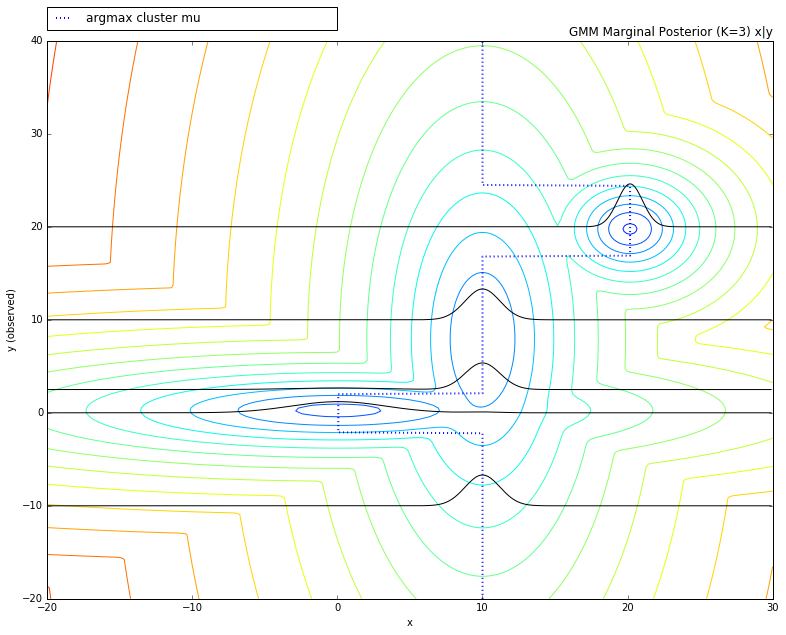

In [8]:
plt.figure(figsize=(13, 10))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
with tf.Session() as sess:
    for y in ys:
        print(y)
        mgmm = gmm.marginalize(y, [1])
        lla = mgmm.score(pts)
        plt.plot(pts.reshape(-1), np.exp(lla) * 10 + y[0], ls='-', c='black')

plt.plot(mle_xs, mle_ys, label='argmax cluster mu', ls =':', c='blue', lw=2)
plt.legend(bbox_to_anchor=(0., 1.02, 0.4, 1.02), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title('GMM Marginal Posterior (K=3) x|y', loc='right')
plt.xlabel('x')
plt.ylabel('y (observed)')
plt.show()